# Fitting NASA K2 time-series to remove systematics

In [1]:
import numpy as np
from astropy.io import fits

In [4]:
hdulist = fits.open('data/k2.fits')

In [5]:
attrs = ['time', 'sap_flux', 'sap_flux_err', 'sap_quality', 'psf_centr1', 'psf_centr2']
d = {attr:hdulist[1].data[attr] for attr in attrs}
d['sap_quality'] = (d['sap_quality'] & 82239) == 0
d['sap_quality'] &= np.isfinite(d['sap_flux']) 
d['sap_quality'] &= np.isfinite(d['sap_flux_err']) 

## Looking at the dataset

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def get_plot():
    k = d['sap_quality']
    fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
    axs[0].scatter(d['time'][k], np.log10(d['sap_flux'][k]), s=0.1, c='k')
    axs[1].scatter(d['psf_centr1'][k], np.log10(d['sap_flux'][k]), s=0.1, c='k')
    axs[2].scatter(d['psf_centr2'][k], np.log10(d['sap_flux'][k]), s=0.1, c='k')
    axs[0].set(ylabel='log$_{10}$ SAP Flux', xlabel='Time [BKJD]')
    axs[1].set(xlabel='PSF Center 1')
    axs[2].set(xlabel='PSF Center 2')
    return fig, axs

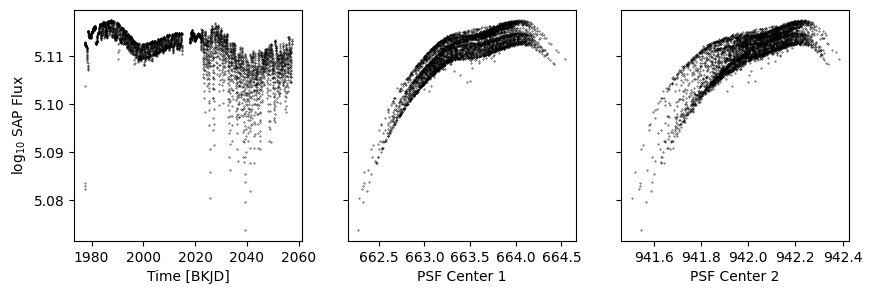

In [8]:
get_plot();

In [9]:
data = np.log10(d['sap_flux'])
errors = d['sap_flux_err'] / (d['sap_flux'] * np.log(10))

## Model 1: A simple polynomial in row position

In [10]:
from lamatrix import Polynomial, Constant

In [11]:
p1 = Polynomial('r', 4)
p = p1 + Constant()

In [12]:
p.fit(data=data, errors=errors, mask=d['sap_quality'], r=d['psf_centr1'])

/Users/chedges/Pandora/repos/lamatrix/src/lamatrix/model.py:326: RuntimeWarning: invalid value encountered in sqrt
  fit_std = self.cov.diagonal() ** 0.5


In [13]:
model = p.evaluate(r=d['psf_centr1'])

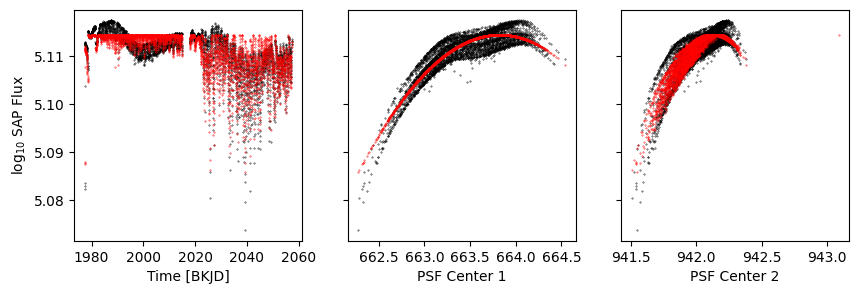

In [14]:
k = d['sap_quality']
fig, axs = get_plot()
axs[0].scatter(d['time'], model, s=0.1, c='r')
axs[1].scatter(d['psf_centr1'], model, s=0.1, c='r')
axs[2].scatter(d['psf_centr2'], model, s=0.1, c='r')

## Model 2: A polynomial in row, and a model for the time dependent astrophysics

In [15]:
from lamatrix import Spline

In [16]:
p1 = Polynomial('r', 4)
astrophysics = Spline('t', np.linspace(1970, 2060, 30))

priors = [(np.median(np.log10(d['sap_flux'][k])), 0.01)]
p = astrophysics + p1 + Constant(priors=priors)

In [17]:
p.fit(data=data, errors=errors, mask=d['sap_quality'], r=d['psf_centr1'], t=d['time'])

In [18]:
model = p.evaluate(r=d['psf_centr1'], t=d['time'])

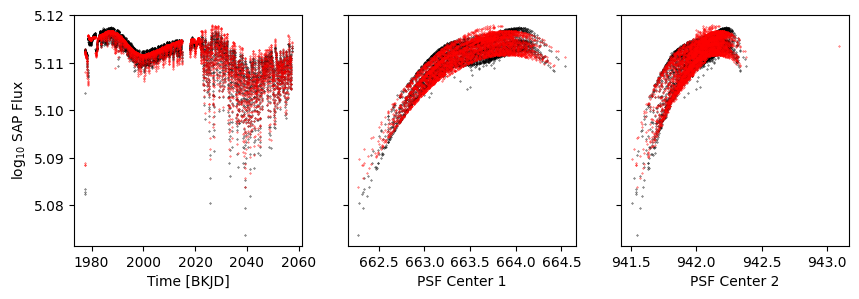

In [19]:
k = d['sap_quality']
fig, axs = get_plot()
axs[0].scatter(d['time'], model, s=0.1, c='r')
axs[1].scatter(d['psf_centr1'], model, s=0.1, c='r')
axs[2].scatter(d['psf_centr2'], model, s=0.1, c='r')

In [20]:
model = p[1:].evaluate(r=d['psf_centr1'], t=d['time'])

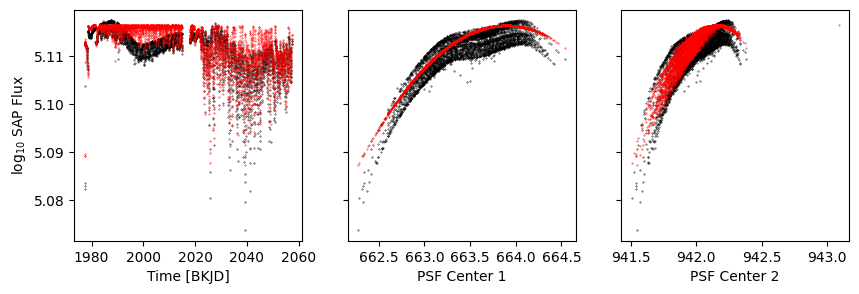

In [21]:
k = d['sap_quality']
fig, axs = get_plot()
axs[0].scatter(d['time'], model, s=0.1, c='r')
axs[1].scatter(d['psf_centr1'], model, s=0.1, c='r')
axs[2].scatter(d['psf_centr2'], model, s=0.1, c='r')

## Model 3: Including step functions

In [22]:
from lamatrix import Step, DistributionsContainer

In [23]:
p1 = Polynomial('r', 4)
astrophysics = Spline('t', np.linspace(1970, 2060, 30))

priors = DistributionsContainer([(np.median(np.log10(d['sap_flux'][k])), 0.01)] * 2)
s = Step('t', [2017], priors=priors)

p = astrophysics + p1 + s

In [24]:
p.fit(data=data, errors=errors, mask=d['sap_quality'], r=d['psf_centr1'], t=d['time'])

In [25]:
model = p.evaluate(r=d['psf_centr1'], t=d['time'])

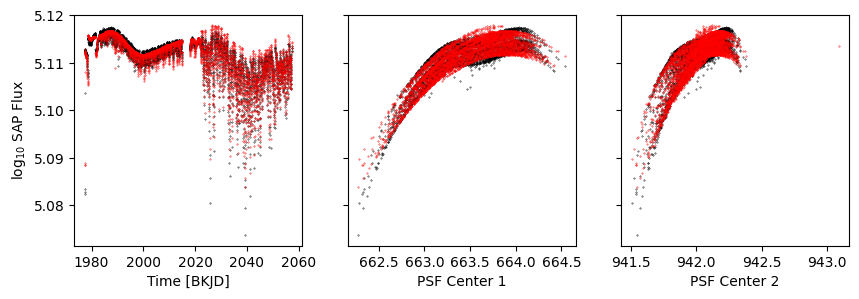

In [26]:
k = d['sap_quality']
fig, axs = get_plot()
axs[0].scatter(d['time'], model, s=0.1, c='r')
axs[1].scatter(d['psf_centr1'], model, s=0.1, c='r')
axs[2].scatter(d['psf_centr2'], model, s=0.1, c='r')

In [27]:
model = p[2].evaluate(r=d['psf_centr1'], t=d['time'])

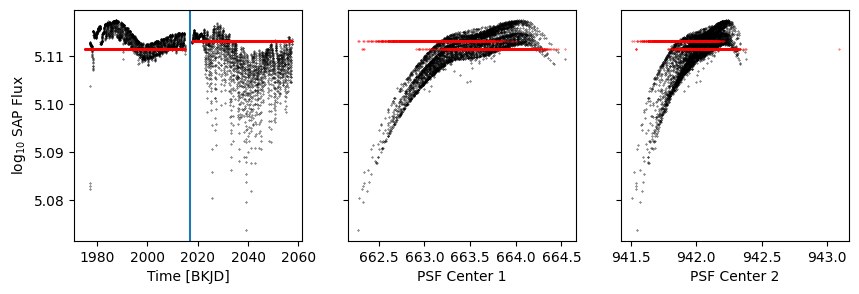

In [28]:
k = d['sap_quality']
fig, axs = get_plot()
axs[0].scatter(d['time'], model, s=0.1, c='r')
axs[1].scatter(d['psf_centr1'], model, s=0.1, c='r')
axs[2].scatter(d['psf_centr2'], model, s=0.1, c='r')

axs[0].axvline(2017)

## Model 4: Splines in time, row positon, and column position. 

In [29]:
p1 = Spline('r', np.linspace(np.nanmin(d['psf_centr1']), np.nanmax(d['psf_centr1']), 15))
p2 = Spline('c', np.linspace(np.nanmin(d['psf_centr2']), np.nanmax(d['psf_centr2']), 15))
astrophysics = Spline('t', np.linspace(1970, 2060, 30))

priors = DistributionsContainer([(np.median(np.log10(d['sap_flux'][k])), 0.01)] * 2)
s = Step('t', [2017], priors=priors)

p1.priors = DistributionsContainer([(0, 0.1)] * p1.width)
p2.priors = DistributionsContainer([(0, 0.1)] * p1.width)

p = astrophysics + p1 + p2 + s

In [30]:
p.fit(data=data, errors=errors, mask=d['sap_quality'], r=d['psf_centr1'], c=d['psf_centr2'], t=d['time'])

In [31]:
model = p.evaluate(r=d['psf_centr1'], c=d['psf_centr2'], t=d['time'])

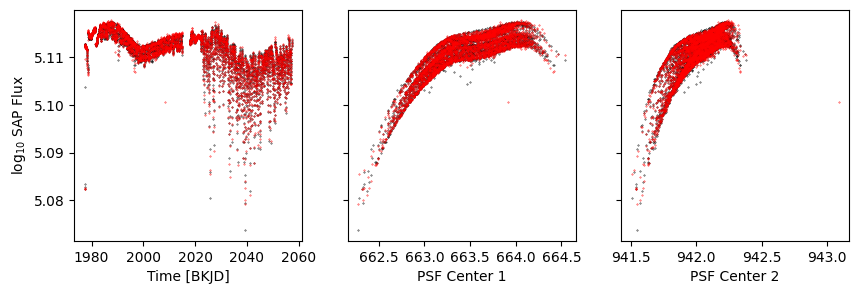

In [32]:
k = d['sap_quality']
fig, axs = get_plot()
axs[0].scatter(d['time'], model, s=0.1, c='r')
axs[1].scatter(d['psf_centr1'], model, s=0.1, c='r')
axs[2].scatter(d['psf_centr2'], model, s=0.1, c='r')

In [33]:
model = p[1:].evaluate(r=d['psf_centr1'], c=d['psf_centr2'], t=d['time'])

<ErrorbarContainer object of 3 artists>

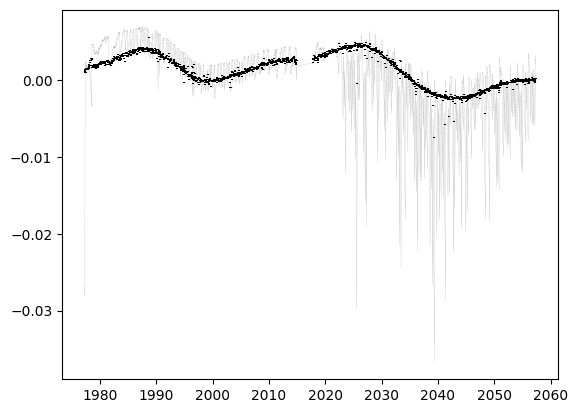

In [34]:
fig, ax = plt.subplots()
ax.errorbar(d['time'][k], (data - np.nanmedian(model))[k], errors[k], c='grey', zorder=-1, lw=0.1)
ax.errorbar(d['time'][k], (data - model)[k], errors[k], c='k', ls='', zorder=10)

In [35]:
p.equation

'\\[f(\\mathbf{r}, \\mathbf{c}, \\mathbf{t}) = w_{0} N_{1, {3}}(\\mathbf{t}) + w_{1} N_{2, {3}}(\\mathbf{t}) + w_{2} N_{3, {3}}(\\mathbf{t}) + w_{3} N_{4, {3}}(\\mathbf{t}) + w_{4} N_{5, {3}}(\\mathbf{t}) + w_{5} N_{6, {3}}(\\mathbf{t}) + w_{6} N_{7, {3}}(\\mathbf{t}) + w_{7} N_{8, {3}}(\\mathbf{t}) + w_{8} N_{9, {3}}(\\mathbf{t}) + w_{9} N_{10, {3}}(\\mathbf{t}) + w_{10} N_{11, {3}}(\\mathbf{t}) + w_{11} N_{12, {3}}(\\mathbf{t}) + w_{12} N_{13, {3}}(\\mathbf{t}) + w_{13} N_{14, {3}}(\\mathbf{t}) + w_{14} N_{15, {3}}(\\mathbf{t}) + w_{15} N_{16, {3}}(\\mathbf{t}) + w_{16} N_{17, {3}}(\\mathbf{t}) + w_{17} N_{18, {3}}(\\mathbf{t}) + w_{18} N_{19, {3}}(\\mathbf{t}) + w_{19} N_{20, {3}}(\\mathbf{t}) + w_{20} N_{21, {3}}(\\mathbf{t}) + w_{21} N_{22, {3}}(\\mathbf{t}) + w_{22} N_{23, {3}}(\\mathbf{t}) + w_{23} N_{24, {3}}(\\mathbf{t}) + w_{24} N_{25, {3}}(\\mathbf{t}) + w_{25} N_{26, {3}}(\\mathbf{t}) + w_{26} N_{1, {3}}(\\mathbf{r}) + w_{27} N_{2, {3}}(\\mathbf{r}) + w_{28} N_{3, {3}}(\\mathbf{r}) + w_{29} N_{4, {3}}(\\mathbf{r}) + w_{30} N_{5, {3}}(\\mathbf{r}) + w_{31} N_{6, {3}}(\\mathbf{r}) + w_{32} N_{7, {3}}(\\mathbf{r}) + w_{33} N_{8, {3}}(\\mathbf{r}) + w_{34} N_{9, {3}}(\\mathbf{r}) + w_{35} N_{10, {3}}(\\mathbf{r}) + w_{36} N_{11, {3}}(\\mathbf{r}) + w_{37} N_{1, {3}}(\\mathbf{c}) + w_{38} N_{2, {3}}(\\mathbf{c}) + w_{39} N_{3, {3}}(\\mathbf{c}) + w_{40} N_{4, {3}}(\\mathbf{c}) + w_{41} N_{5, {3}}(\\mathbf{c}) + w_{42} N_{6, {3}}(\\mathbf{c}) + w_{43} N_{7, {3}}(\\mathbf{c}) + w_{44} N_{8, {3}}(\\mathbf{c}) + w_{45} N_{9, {3}}(\\mathbf{c}) + w_{46} N_{10, {3}}(\\mathbf{c}) + w_{47} N_{11, {3}}(\\mathbf{c}) + w_{48} \\mathbb{I}_{[{-\\infty}, {2017}]}(\\mathbf{t}) + w_{49} \\mathbb{I}_{[{2017}, {\\infty}]}(\\mathbf{t})\\]'

## Model 6: Including cross terms

In [36]:
p1 = Spline('r', np.linspace(np.nanmin(d['psf_centr1']), np.nanmax(d['psf_centr1']), 15))
p2 = Spline('c', np.linspace(np.nanmin(d['psf_centr2']), np.nanmax(d['psf_centr2']), 15))
astrophysics = Spline('t', np.linspace(1970, 2060, 30))

priors = DistributionsContainer([(np.median(np.log10(d['sap_flux'][k])), 0.01)] * 2)
s = Step('t', [2017], priors=priors)

p1.priors = DistributionsContainer([(0, 0.1)] * p1.width)
p2.priors = DistributionsContainer([(0, 0.1)] * p1.width)

p = astrophysics + p1 + p2 + p1 * p2 + s 

In [37]:
p

JointModel
	Spline(t)[n, 27]
	Spline(r)[n, 12]
	Spline(c)[n, 12]
	CrosstermModel(r, c)[n, 144]
	Step(t)[n, 2]

In [38]:
p.fit(data=data, errors=errors, mask=d['sap_quality'], r=d['psf_centr1'], c=d['psf_centr2'], t=d['time'])

In [39]:
model = p.evaluate(r=d['psf_centr1'], c=d['psf_centr2'], t=d['time'])

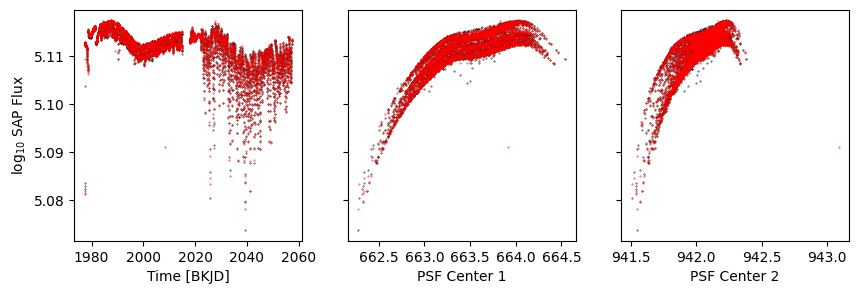

In [40]:
k = d['sap_quality']
fig, axs = get_plot()
axs[0].scatter(d['time'], model, s=0.1, c='r')
axs[1].scatter(d['psf_centr1'], model, s=0.1, c='r')
axs[2].scatter(d['psf_centr2'], model, s=0.1, c='r')

In [41]:
model = p[1:].evaluate(r=d['psf_centr1'], c=d['psf_centr2'], t=d['time'])

<ErrorbarContainer object of 3 artists>

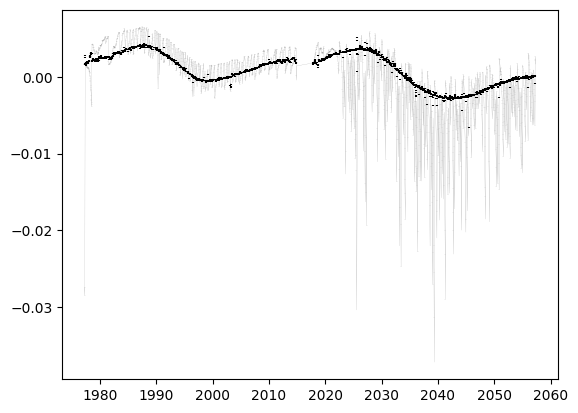

In [42]:
fig, ax = plt.subplots()
ax.errorbar(d['time'][k], (data - np.nanmedian(model))[k], errors[k], c='grey', zorder=-1, lw=0.1)
ax.errorbar(d['time'][k], (data - model)[k], errors[k], c='k', ls='', zorder=10)

In [43]:
R, C = np.mgrid[662:665:80j, 941:943:79j]

In [44]:
p[1]

Spline(r)[n, 12]

In [45]:
p[1].priors

DistributionContainer
	[(0, 0.1), (0, 0.1), (0, 0.1), (0, 0.1), (0, 0.1), (0, 0.1), (0, 0.1), (0, 0.1), (0, 0.1), (0, 0.1), (0, 0.1), (0, 0.1)]

In [46]:
p[1].priors.sample()

array([ 0.16692599,  0.06418931, -0.03082698, -0.06964058,  0.1366119 ,
        0.09558837, -0.19841951, -0.05788737, -0.15226211,  0.15364012,
       -0.05229935,  0.09449464])

[Text(0.5, 0, 'PSF Centr 2'),
 Text(0, 0.5, 'PSF Centr 1'),
 None,
 Text(0.5, 1.0, 'Best Fit')]

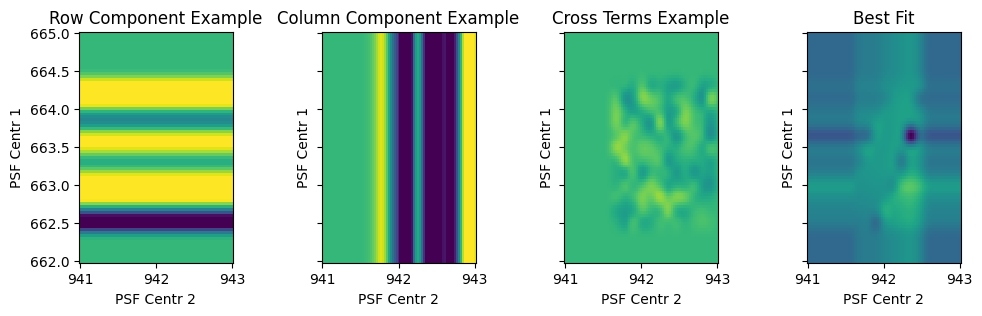

In [47]:
fig, ax = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(12, 3))
w = p[1].priors.sample()
ax[0].pcolormesh(C, R, p[1].design_matrix(r=R).dot(w), vmin=-0.1, vmax=0.05)
ax[0].set(xlabel='PSF Centr 2', ylabel='PSF Centr 1', aspect='equal', title='Row Component Example')

w = p[2].priors.sample()
ax[1].pcolormesh(C, R, p[2].design_matrix(c=C).dot(w), vmin=-0.1, vmax=0.05)
ax[1].set(xlabel='PSF Centr 2', ylabel='PSF Centr 1', aspect='equal', title='Column Component Example')


w = p[3].priors.sample()
ax[2].pcolormesh(C, R, p[3].design_matrix(r=R, c=C).dot(w), vmin=-0.1, vmax=0.05)
ax[2].set(xlabel='PSF Centr 2', ylabel='PSF Centr 1', aspect='equal', title='Cross Terms Example')

w = p[1:-1].posteriors.mean
ax[3].pcolormesh(C, R, p[1:-1].design_matrix(t=R**0 * 2010, r=R, c=C).dot(w), vmin=-0.05, vmax=0.1)
ax[3].set(xlabel='PSF Centr 2', ylabel='PSF Centr 1', aspect='equal', title='Best Fit')


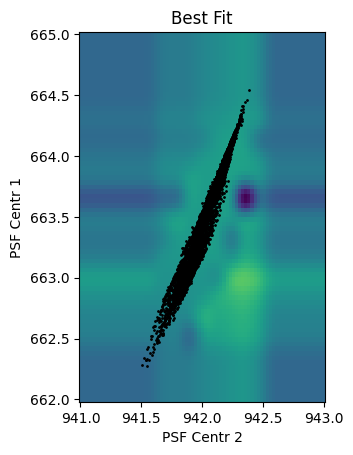

In [48]:
fig, ax = plt.subplots()
w = p[1:-1].posteriors.mean
ax.pcolormesh(C, R, p[1:-1].design_matrix(t=R**0 * 2010, r=R, c=C).dot(w), vmin=-0.05, vmax=0.1)
ax.set(xlabel='PSF Centr 2', ylabel='PSF Centr 1', aspect='equal', title='Best Fit')
ax.scatter(d['psf_centr2'][k], d['psf_centr1'][k], c='k', s=1)

In [49]:
p.save('test.json')